In [21]:
import scanpy as sc
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding
import gdown
import os

# Load HVG Subset TICA Dataset

In [29]:
url = "https://drive.google.com/uc?id=1KYVJYgem5vLgOWdlZnJqSf2oGRq8bJOl"
output = 'tica.h5ad'
if not os.path.exists("tica.h5ad"):
    gdown.download(url, output, quiet=False)
adata = sc.read("tica.h5ad")
adata

Downloading...
From: https://drive.google.com/uc?id=1KYVJYgem5vLgOWdlZnJqSf2oGRq8bJOl
To: /Users/ceglian/Analysis/genevector_examples/tica.h5ad
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24.3M/24.3M [00:02<00:00, 11.4MB/s]


AnnData object with n_obs × n_vars = 24834 × 1000
    obs: 'nCount_RNA', 'nFeature_RNA', 'patient', 'percent.mt', 'gender', 'source', 'subtype', 'cluster_kmeans_k6', 'cell_type'
    uns: 'hvg'
    obsm: 'X_umap'

In [30]:
dataset = GeneVectorDataset(adata)

Loading Expression.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2694738/2694738 [00:24<00:00, 109438.47it/s]


Reindexing Cooc


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24834/24834 [00:00<00:00, 25650.40it/s]


In [31]:
if retrain:
    cmps = GeneVector(dataset,output_file="embeddings/tica.vec",emb_dimension=100)
    cmps.train(10000,threshold=1e-8)

Generating inputs and outputs.


  0%|▏                                                                                                                   | 686/499500 [00:00<02:17, 3622.29it/s]/Users/ceglian/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:1124: RuntimeWarning: invalid value encountered in true_divide
  hist /= s
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2177.26it/s]


# Load Embedding

In [43]:
embed = GeneEmbedding("embeddings/tica.vec", dataset,vector="average")
print(embed.compute_similarities("CD3D").head(20))

Loading average of 1st and 2nd weights.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3310421.47it/s]

       Gene  Similarity
0      CD3D    1.000000
1      CD3G    0.919153
2      IL32    0.905473
3       CD2    0.901621
4       LCK    0.899897
5      TRAC    0.897106
6      CD52    0.893137
7     ITM2A    0.889803
8      CD3E    0.887146
9     SYNE2    0.886308
10   IFITM1    0.883600
11   SH2D1A    0.878016
12    TRBC2    0.878013
13   CLEC2D    0.876980
14     CD69    0.872961
15  TSC22D3    0.870059
16    GAPDH    0.869093
17     ACTB    0.869041
18     NKG7    0.868563
19   S100A4    0.867620


# Generate Cell Embedding

In [24]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()

normalizing counts per cell
    finished (0:00:00)
Loading Expression.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24834/24834 [00:09<00:00, 2607.94it/s]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

# Summarize Cell Types into 3 Coarse Labels

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7
{'Myeloid', 'B/Plasma', 'T Cell'}


/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


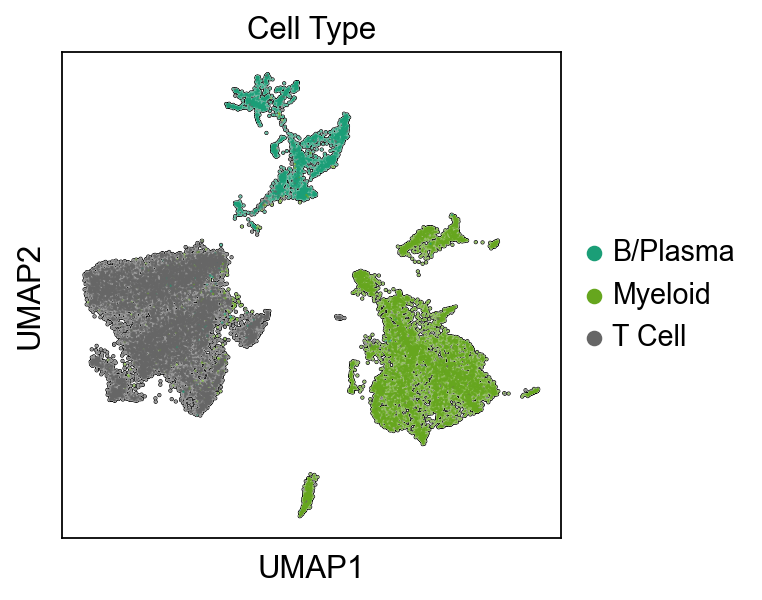

In [7]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

ct = []
for x in adata.obs["cell_type"]:
    if "T " in x:
        ct.append("T Cell")
    elif "mDC" in x or "cDC" in x or "pDC" in x:
        ct.append("Myeloid")
    elif "mono" in x.lower():
        ct.append("Myeloid")
    elif "TAM" in x:
        ct.append("Myeloid")
    elif "B " in x:
        ct.append("B/Plasma")
    elif "NK" in x:
        ct.append("T Cell")
    elif "Th" in x:
        ct.append("T Cell")
    elif "Mast" in x:
        ct.append("Myeloid")
    else:
        ct.append(x)
print(set(ct))
adata.obs["coarse_cell_type"] = ct

sc.pl.umap(adata,palette="Dark2",color=["coarse_cell_type"],title="Cell Type",
           add_outline=True)

# Define Markers for Cell Type Assignment

In [9]:
import pandas

markers = dict()
markers["T Cell"] = ["CD3D","CD3G","CD3E","IL32","TRAC","CD2"]
markers["B/Plasma"] = ["CD79A","CD79B","MZB1","CD19","BANK1"]
markers["Myeloid"] = ["LYZ","CST3","AIF1","CD68","C1QA","C1QB","C1QC"]

# Cell Type Classification

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24834/24834 [00:08<00:00, 2835.41it/s]
/Users/ceglian/miniconda3/lib/python3.9/site-packages/genevector-0.0.1-py3.9.egg/genevector/embedding.py:550: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


T Cell
B/Plasma
Myeloid


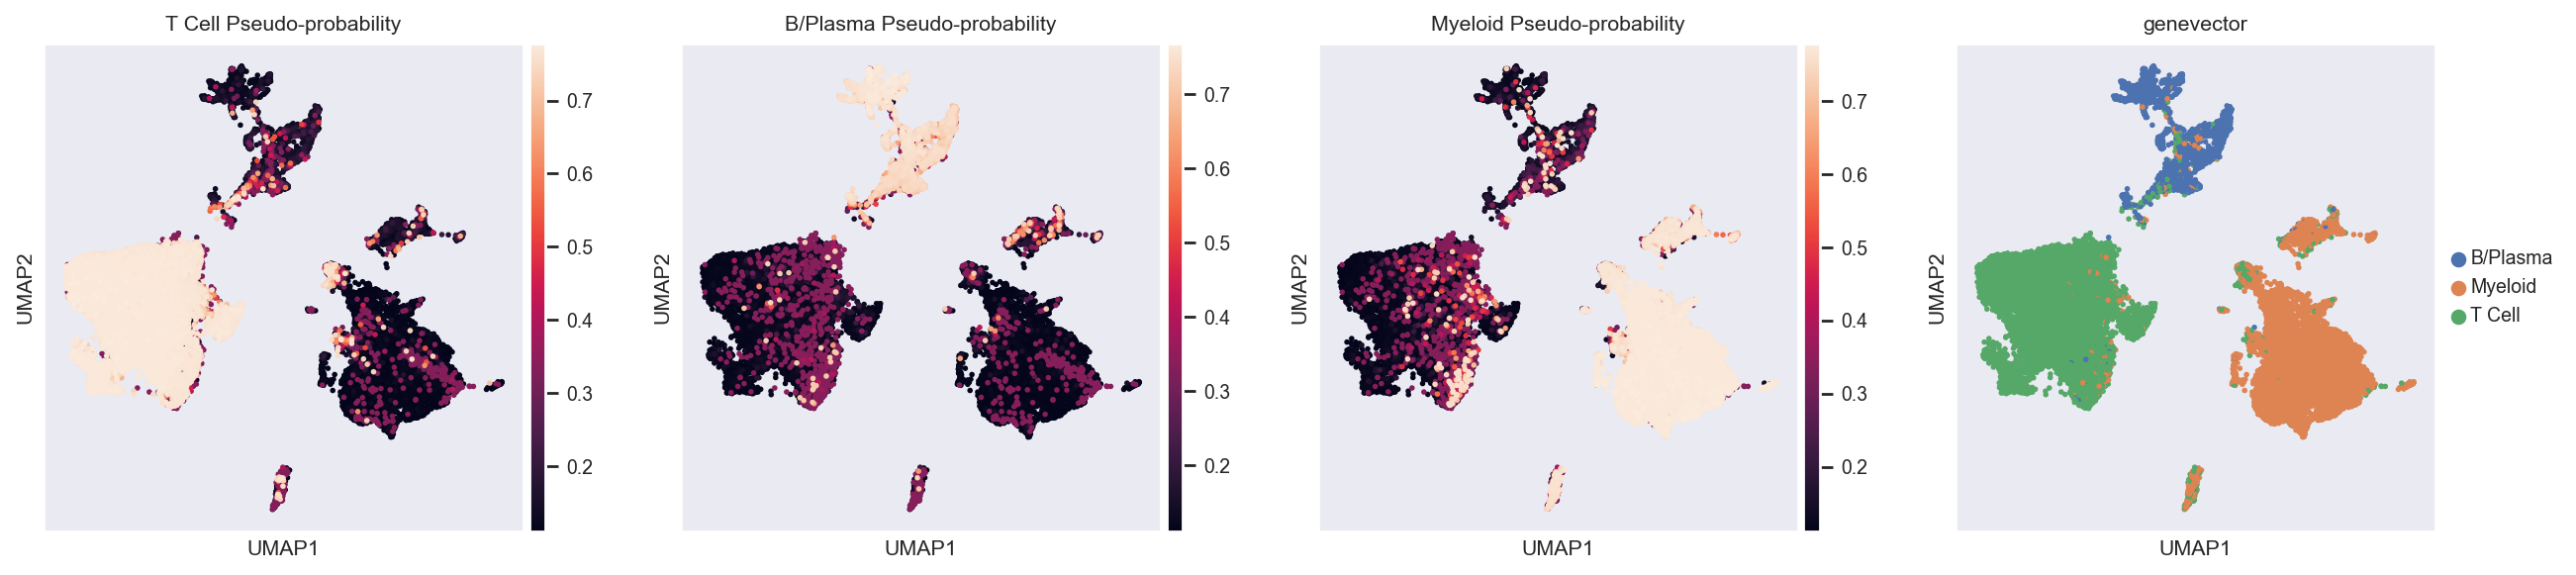

In [10]:
import seaborn as sns
sns.set(font_scale=0.8)
%timeit
annotated_adata = cembed.phenotype_probability(adata,markers,dict())
prob_cols = [x for x in annotated_adata.obs.columns.tolist() if "Pseudo-probability" in x]
sc.pl.umap(annotated_adata,color=prob_cols+["genevector"],size=25)

# Plot Assigned vs. Original and Plot Confusion Matrix

/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


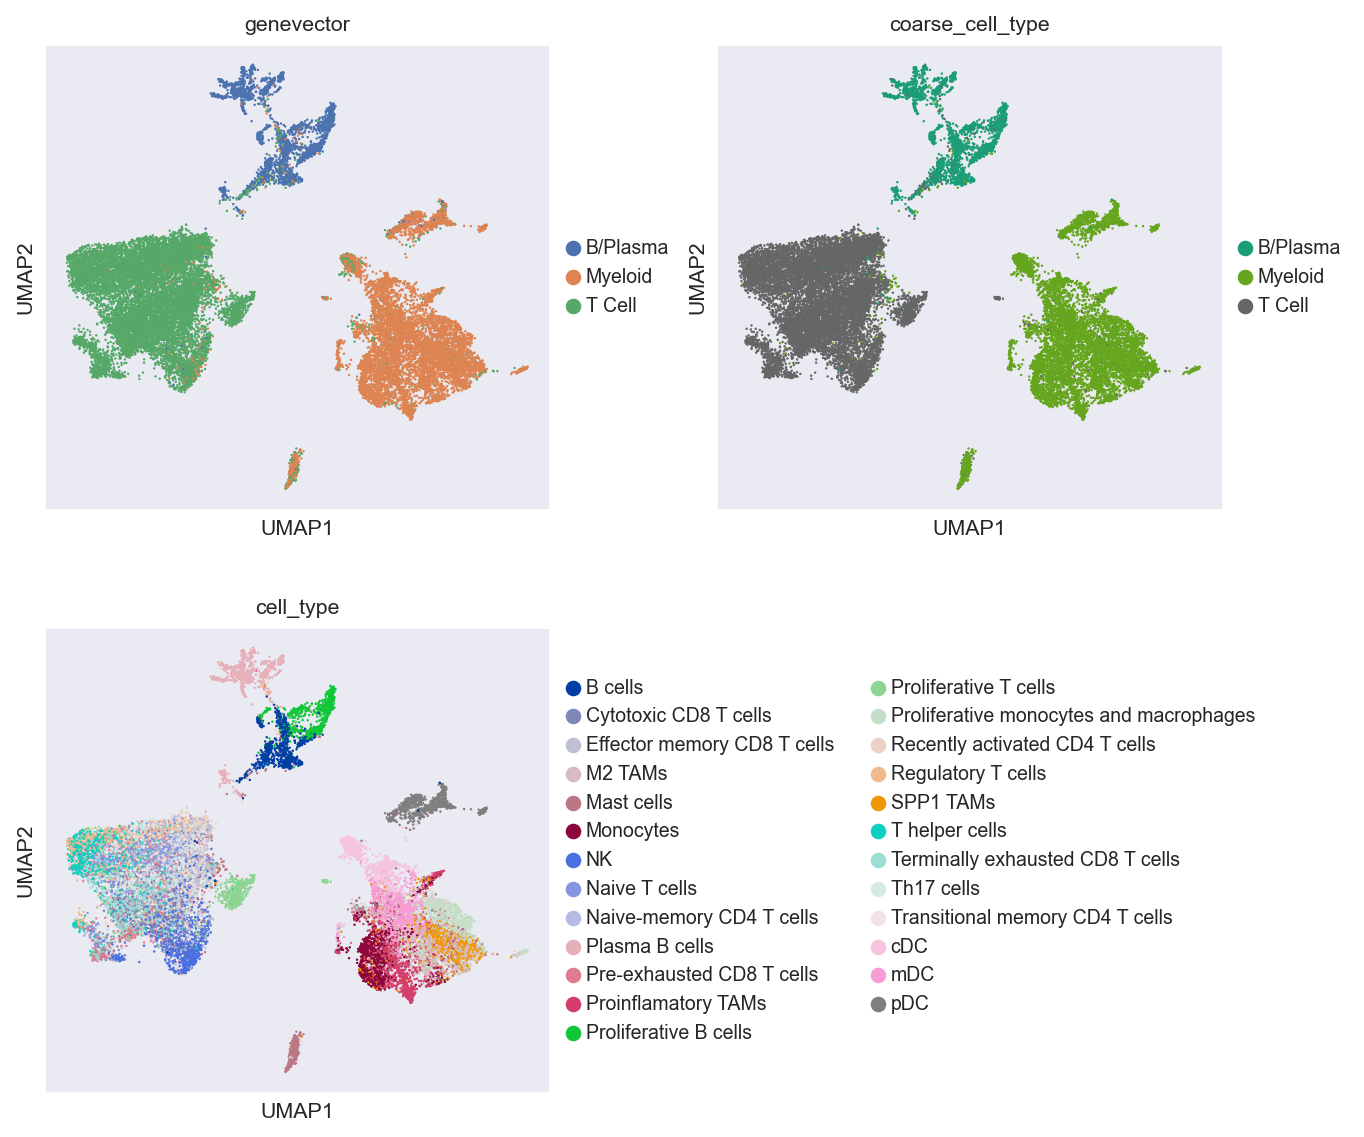

In [11]:
sc.pl.umap(annotated_adata,color=["genevector","coarse_cell_type","cell_type"],ncols=2)

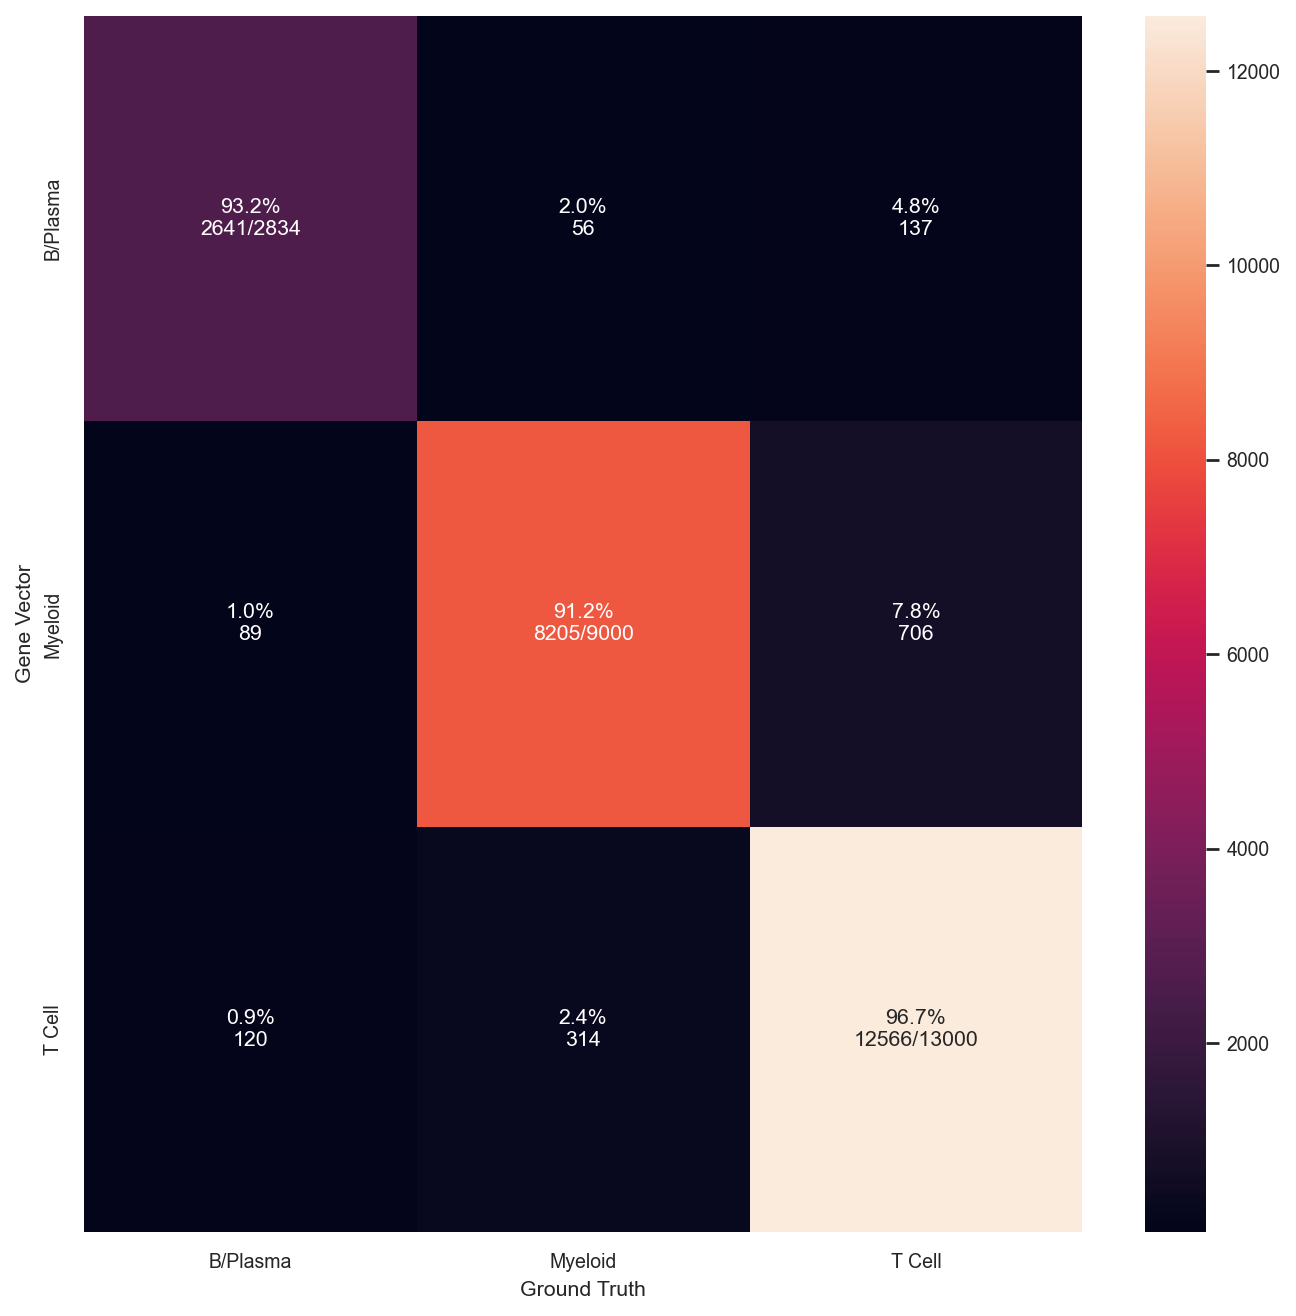

In [12]:
cembed.plot_confusion_matrix(annotated_adata,"coarse_cell_type","genevector")

/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


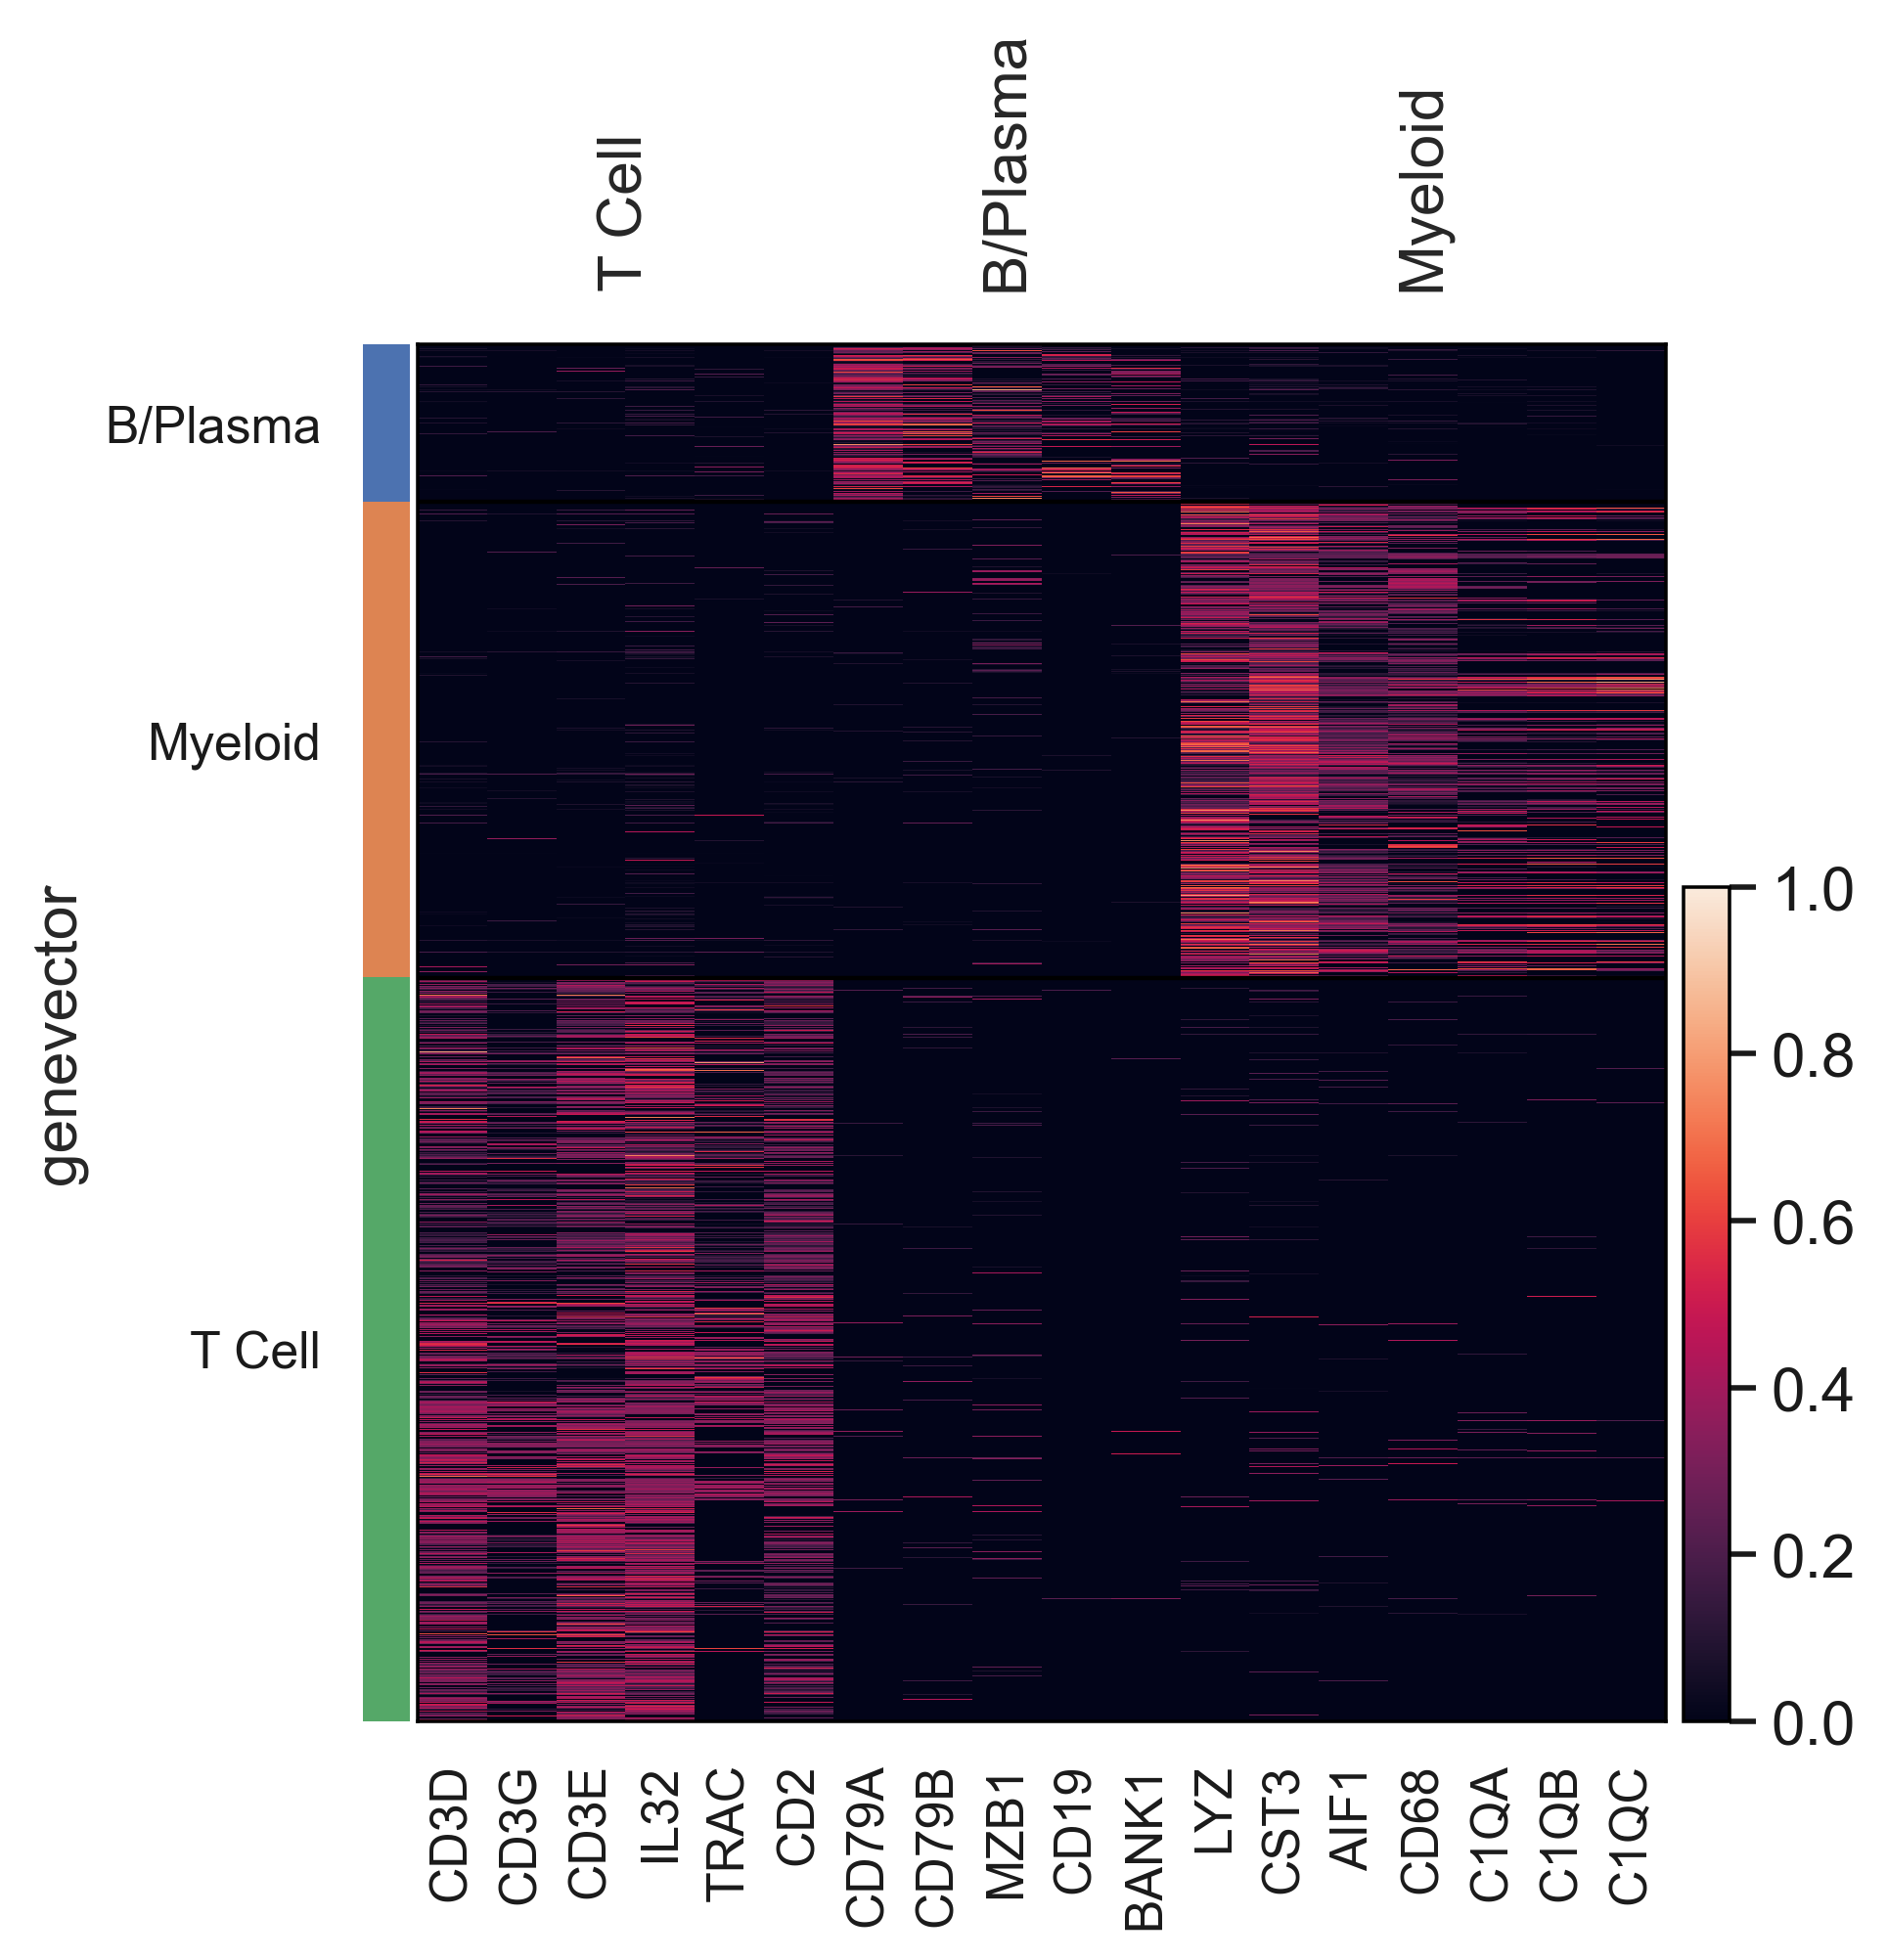

In [17]:
sc.pl.heatmap(annotated_adata,markers,groupby="genevector",standard_scale="var")

/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


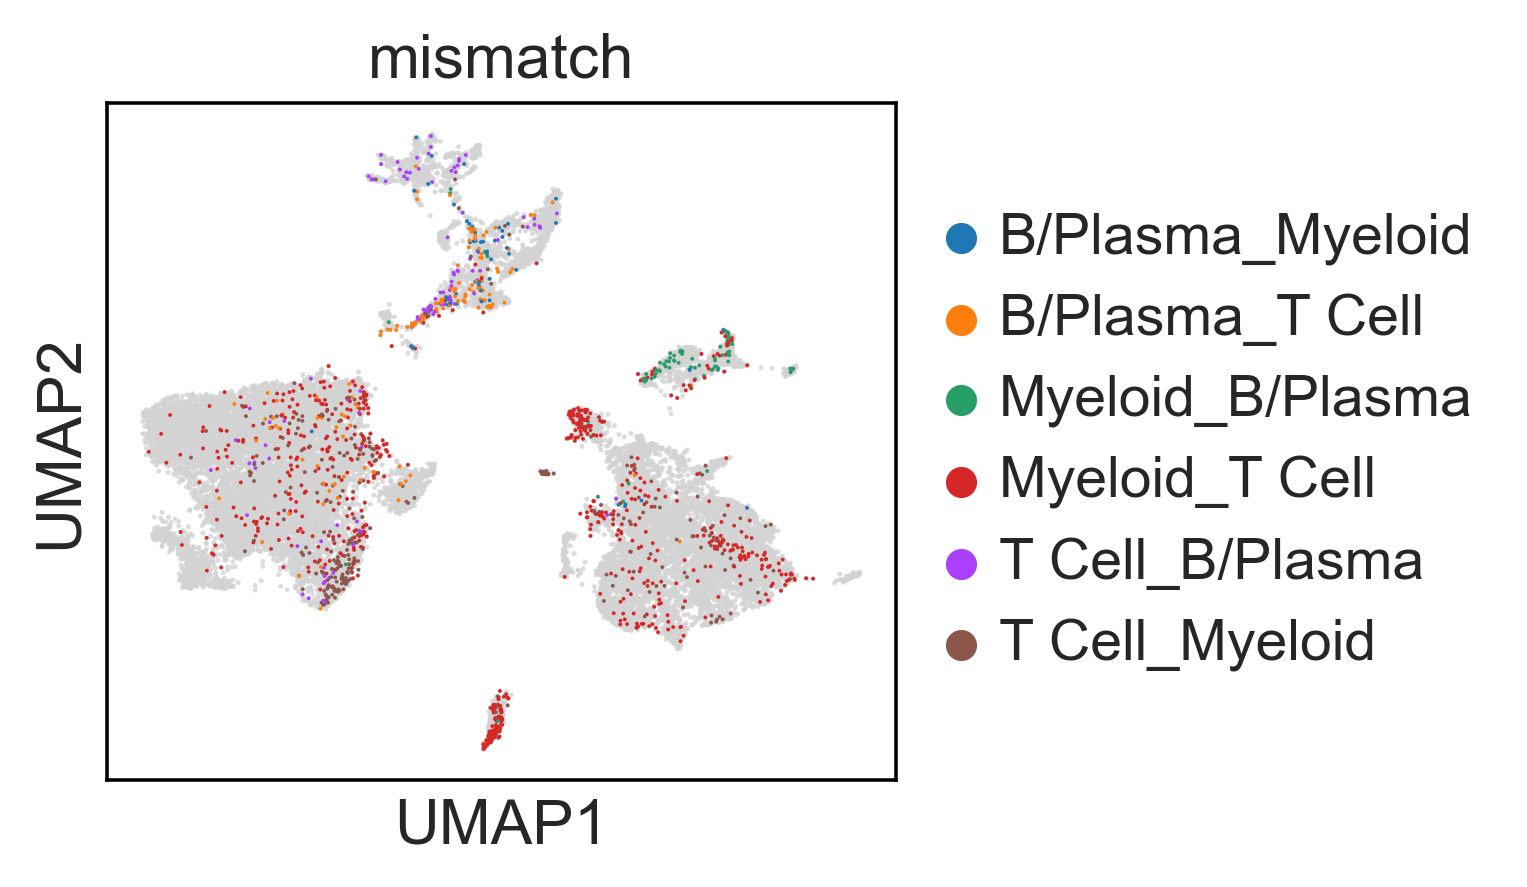

In [15]:
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi=160, facecolor='white')
mismatch = []
for x,y,z in zip(annotated_adata.obs.index.tolist(),
                 annotated_adata.obs["coarse_cell_type"],
                 annotated_adata.obs["genevector"]):
    if y != z:
        mismatch.append("{}_{}".format(y,z))
    else:
        mismatch.append("Correct")
annotated_adata.obs["mismatch"] = mismatch

fig, ax = plt.subplots(1,1,figsize=(5,3))
subsub = annotated_adata[annotated_adata.obs["mismatch"]!="Correct"]
sc.pl.umap(annotated_adata,alpha=0.8,ax=ax,show=False)
sc.pl.umap(subsub,color="mismatch",ax=ax,show=False,s=3)
fig.tight_layout()

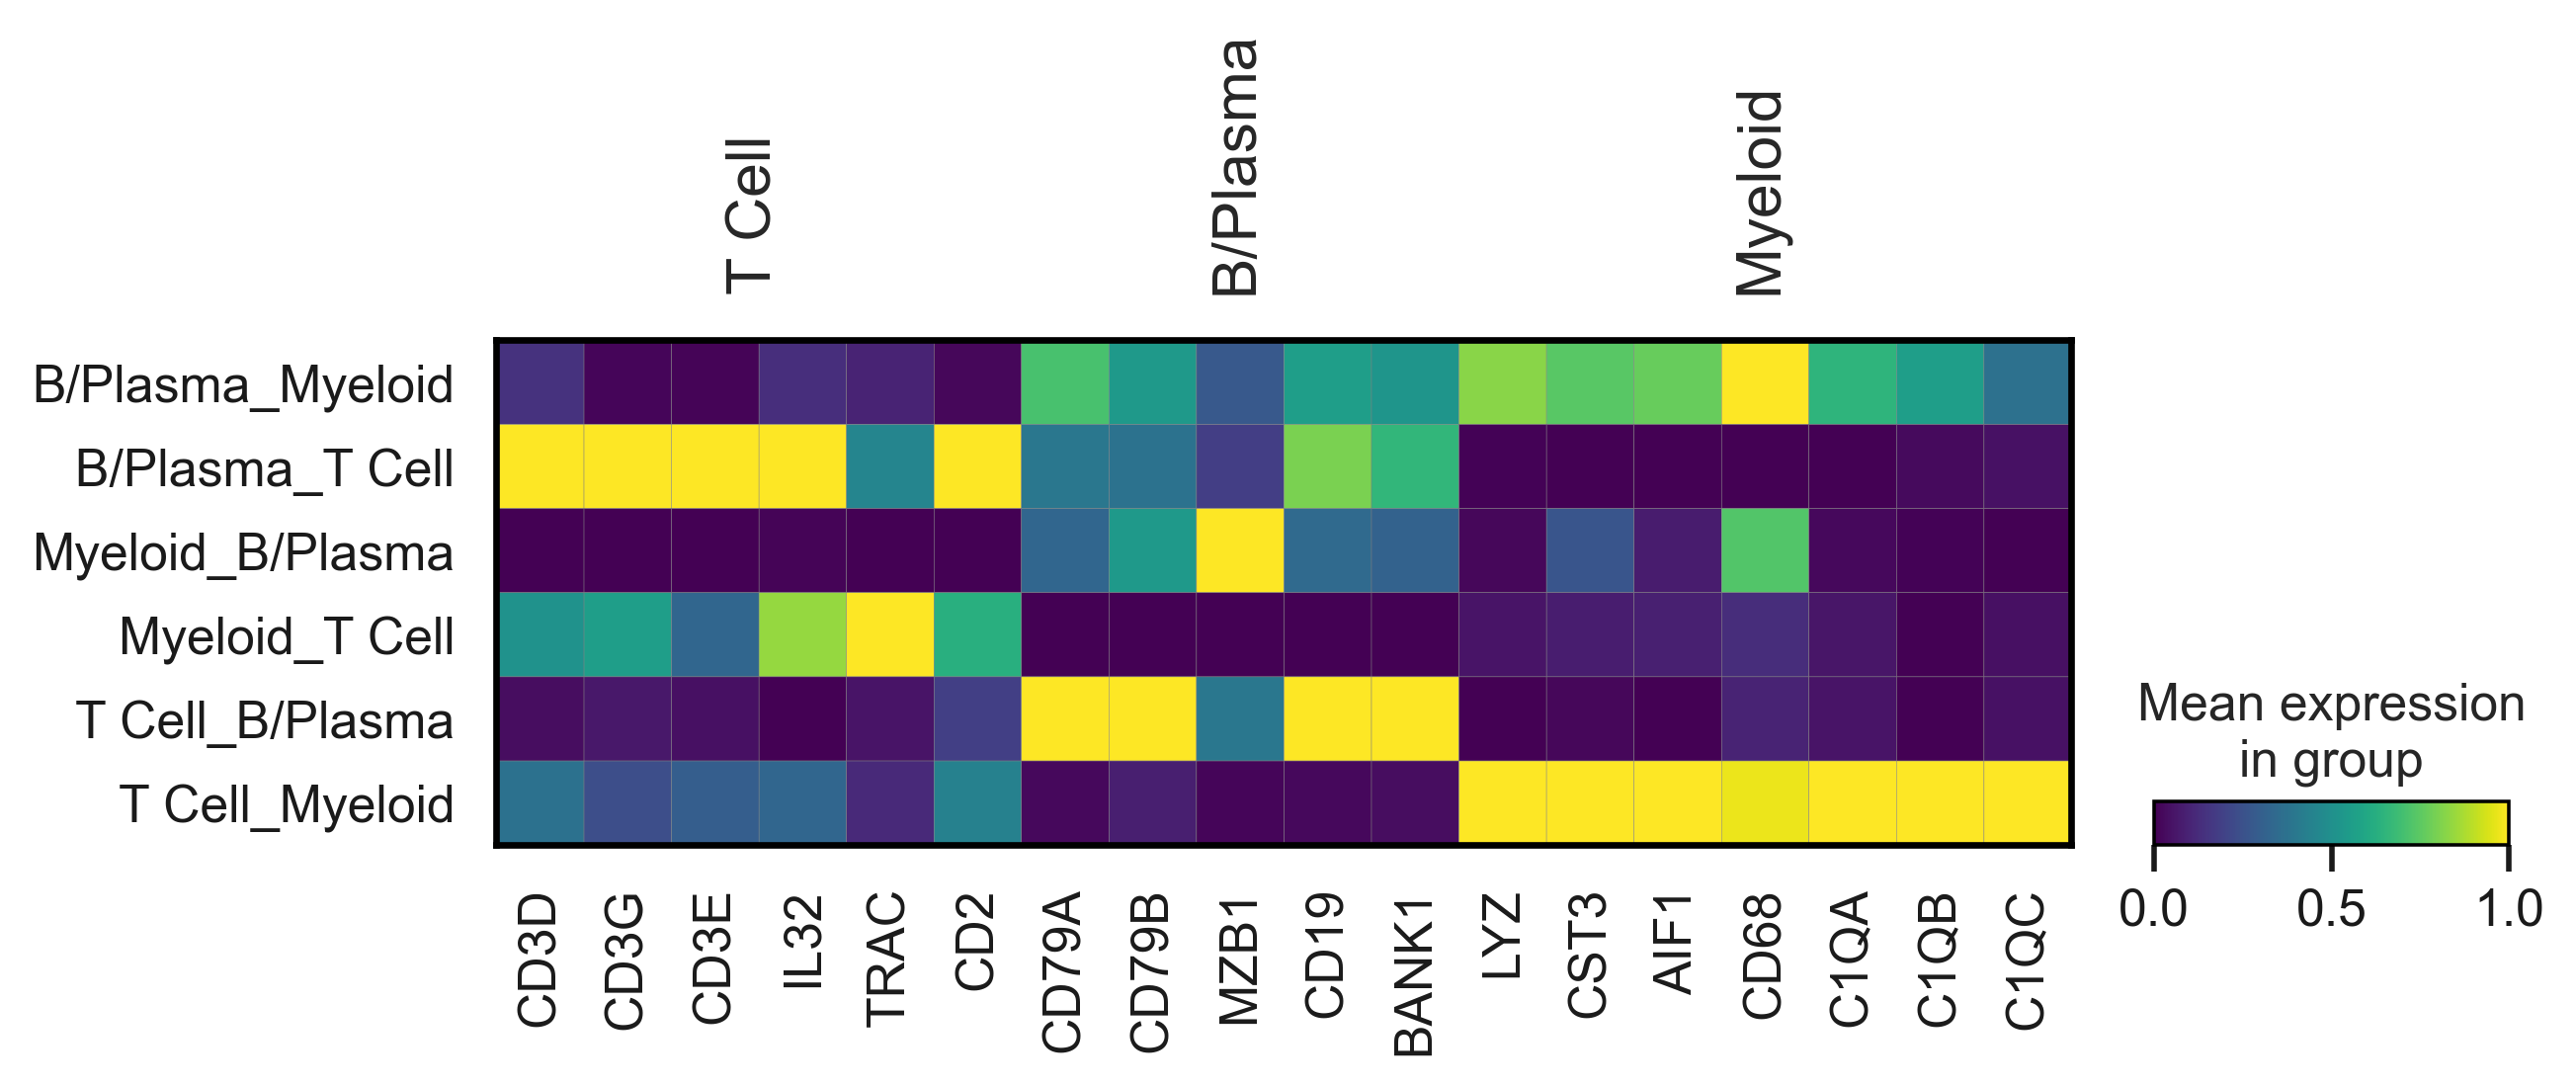

In [16]:
sc.pl.matrixplot(subsub,markers,groupby="mismatch",standard_scale="var")

# Run Gene Pair and TF-Target Analysis

In [25]:
from scipy.stats import pearsonr
import scipy
import pandas

def correlation(gene1,gene2,adata):
    prof1 = adata.X[:,adata.var.index.tolist().index(gene1)]
    prof2 = adata.X[:,adata.var.index.tolist().index(gene2)]
    res = scipy.stats.pearsonr(prof1, prof2)
    if res.pvalue > 0.05:
        return 0.
    return res.statistic

db = pandas.read_csv("trrust_rawdata.human.tsv",sep="\t", header=None)
import collections
trrust = collections.defaultdict(dict)
for x,y,z in zip(db[0],db[1],db[2]):
    trrust[x][y] = z
tftarget = collections.defaultdict(set)
df = pandas.read_csv("TF-Target-information.txt",sep="\t")
for tf, target in zip(df["TF"],df["target"]):
    tftarget[tf].add(target)
import tqdm
rsimilarities = dict()
for gene in tqdm.tqdm(embed.genes):
    df = embed.compute_similarities(gene)
    rsimilarities[gene] = dict(zip(df["Gene"],df["Similarity"]))   

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.30it/s]


In [33]:
adata = sc.read("tica.h5ad")
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata,max_value=10.)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [34]:
import itertools
tftarget = collections.defaultdict(set)
df = pandas.read_csv("/Users/ceglian/Downloads/TF-Target-information.txt",sep="\t")
for tf, target in zip(df["TF"],df["target"]):
    tftarget[tf].add(target)
    
mis = []
correlations = []
cosinet = []
cosine = []
tf = []
tft = []
tflabel= []
pairs = []
for pair in tqdm.tqdm(list(itertools.combinations(adata.var.index.tolist(),2))):
    co = correlation(pair[0],pair[1],adata)
    correlations.append(co)
    mi = dataset.mi_scores[pair[0]][pair[1]]
    mis.append(mi)
    if pair[0] in trrust and pair[1] in trrust[pair[0]] and trrust[pair[0]][pair[1]] == "Activation":
        tflabel.append("Activator")
    elif pair[0] in trrust and pair[1] in trrust[pair[0]] and trrust[pair[0]][pair[1]] == "Repression":
        tflabel.append("Repressor")
    else:
        tflabel.append("_Other")
    if pair[0] in tftarget and pair[1] in tftarget[pair[0]]:
        tf.append("TF-Target")
    else:
        tf.append("_Other")
    cosine.append(rsimilarities[pair[0].upper()][pair[1].upper()])
    pairs.append("{}-{}".format(pair[0],pair[1]))

mis = [x/100. for x in mis]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499500/499500 [03:27<00:00, 2405.26it/s]


In [35]:
df = pandas.DataFrame.from_dict({"Corr":correlations,"MI":mis,"Cosine":cosine,"Regulation":tflabel,"TF":tf,"Pair":pairs})
df = df[df["Corr"]!=0.]
annotation = []
for x,y in zip(df["Regulation"],df["TF"]):
    if y != "TF-Target":
        annotation.append("Gene Pair")
    elif y == "TF-Target" and x == "_Other":
        annotation.append("TF-Target")
    else:
        annotation.append(x)
df["Annotation"] = annotation
df

Corr        MI    Cosine Regulation      TF                Pair  \
0      -0.013729  0.068218  0.370892     _Other  _Other       TMEM176A-ICA1   
1      -0.034804  0.054035  0.538399     _Other  _Other       TMEM176A-CD38   
2       0.080643  0.062107  0.681771     _Other  _Other       TMEM176A-PDK4   
3      -0.031171  0.088280  0.408961     _Other  _Other       TMEM176A-MATK   
4      -0.046692  0.041415  0.547101     _Other  _Other      TMEM176A-CD79B   
...          ...       ...       ...        ...     ...                 ...   
499492  0.152080  0.000000  0.791378     _Other  _Other     CCL3L1-C19orf59   
499493  0.195731  0.126928  0.776380     _Other  _Other          CCL3L1-IL8   
499495  0.059255  0.000000  0.299643     _Other  _Other  RNU6.514P-C19orf59   
499496  0.039090  0.918296  0.076243     _Other  _Other       RNU6.514P-IL8   
499499  0.244072  0.000000  0.862440     _Other  _Other        C19orf59-IL8   

       Annotation  
0       Gene Pair  
1       Gene Pair  
2       Gene Pair  
3       Gene Pair  
4       Gene Pair  
...           ...  
499492  Gene Pair  
499493  Gene Pair  
499495  Gene Pair  
499496  Gene Pair  
499499  Gene Pair  

[315365 rows x 7 columns]

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Gene Pair v.s. TF-Target: t-test independent samples with Bonferroni correction, P_val=1.071e-01 stat=-2.100e+00
Gene Pair v.s. Activator: t-test independent samples with Bonferroni correction, P_val=3.765e-04 stat=-3.835e+00
Gene Pair v.s. Repressor: t-test independent samples with Bonferroni correction, P_val=4.154e-03 stat=-3.198e+00
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Gene Pair v.s. TF-Target: t-test independent samples with Bonferroni correction, P_val=1.373e-124 stat=-2.380e+01
Gene Pair v.s. Activator: t-test independent samples wit

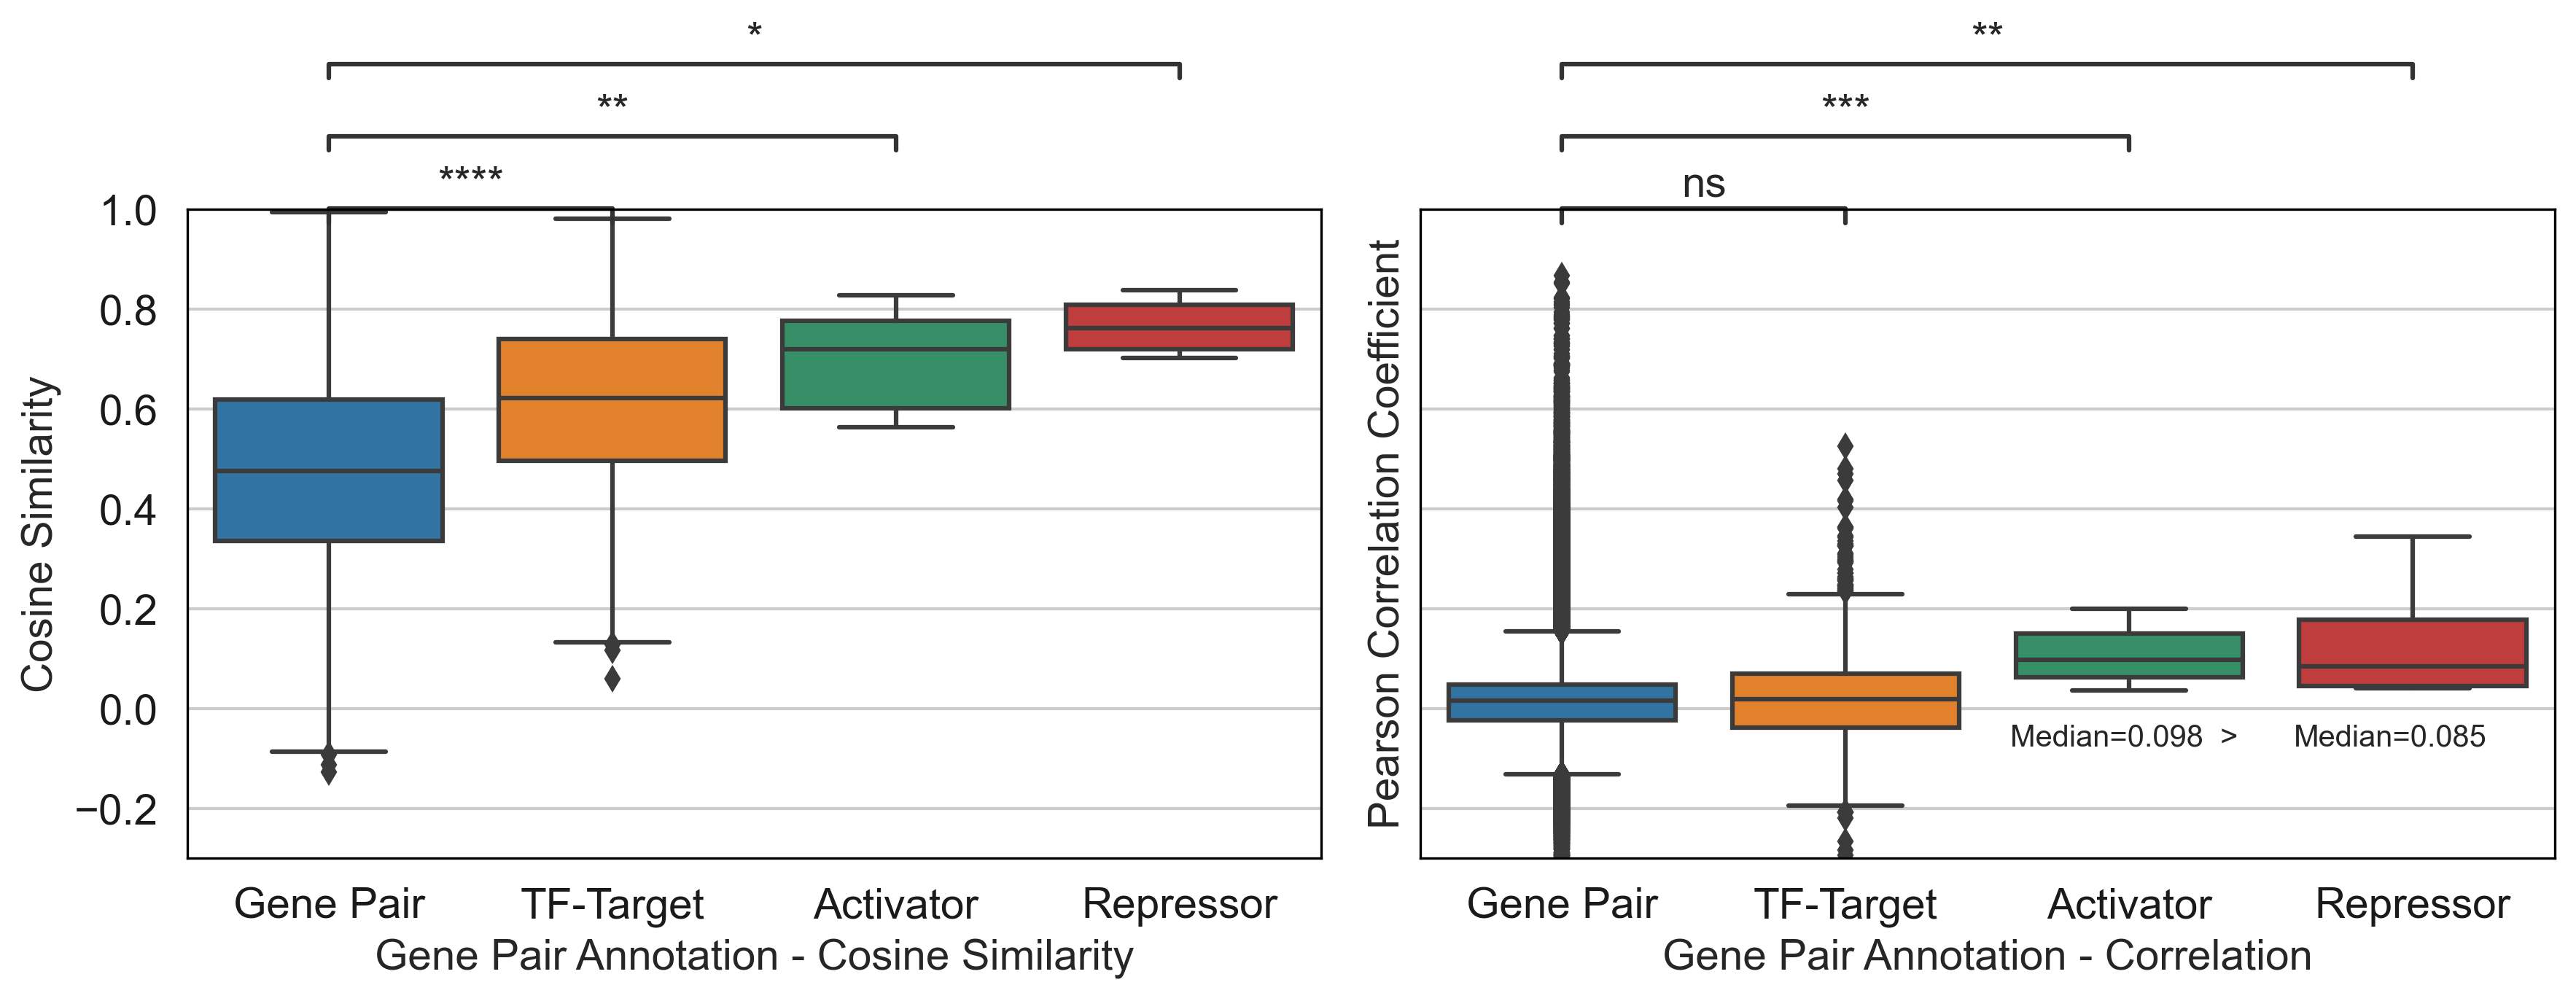

In [38]:
from statannot import add_stat_annotation
import seaborn as sns
import numpy
import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150,facecolor='white')
import matplotlib.pyplot as plt
x = "Annotation"
y = "Corr"
order = ['Gene Pair','TF-Target', 'Activator', 'Repressor']
fig, ax = plt.subplots(1,2,figsize=(12,5),sharey=True)
axz = sns.boxplot(data=df, x=x, y=y, order=order,ax=ax[1])
axz, test_results = add_stat_annotation(axz, data=df, x=x, y=y, order=order,
                                   box_pairs=[("Gene Pair", "TF-Target"),
                                              ("Gene Pair", "Repressor"), ("Gene Pair", "Activator")],
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)
y = "Cosine"
order = ['Gene Pair','TF-Target', 'Activator', 'Repressor']
axz = sns.boxplot(data=df, x=x, y=y, order=order,ax=ax[0])
axz, test_results = add_stat_annotation(axz, data=df, x=x, y=y, order=order,
                                   box_pairs=[("Gene Pair", "TF-Target"),
                                              ("Gene Pair", "Repressor"), ("Gene Pair", "Activator")],
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)
med = numpy.median(df[df["Annotation"]=="Repressor"]["Corr"])
amed = numpy.median(df[df["Annotation"]=="Activator"]["Corr"])
ax[1].text(x=2.58,y=med-0.16,s="Median={}".format(round(med,3)),size=10)
ax[1].text(x=1.58,y=med-0.16,s="Median={}  >".format(round(amed,3)),size=10)
ax[1].set_ylabel("Pearson Correlation Coefficient")
ax[0].set_ylabel("Cosine Similarity")
ax[1].set_xlabel("Gene Pair Annotation - Correlation")
ax[0].set_xlabel("Gene Pair Annotation - Cosine Similarity")
plt.ylim(-.3,1.0)
plt.tight_layout()
plt.savefig('/Users/ceglian/comp.pdf')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


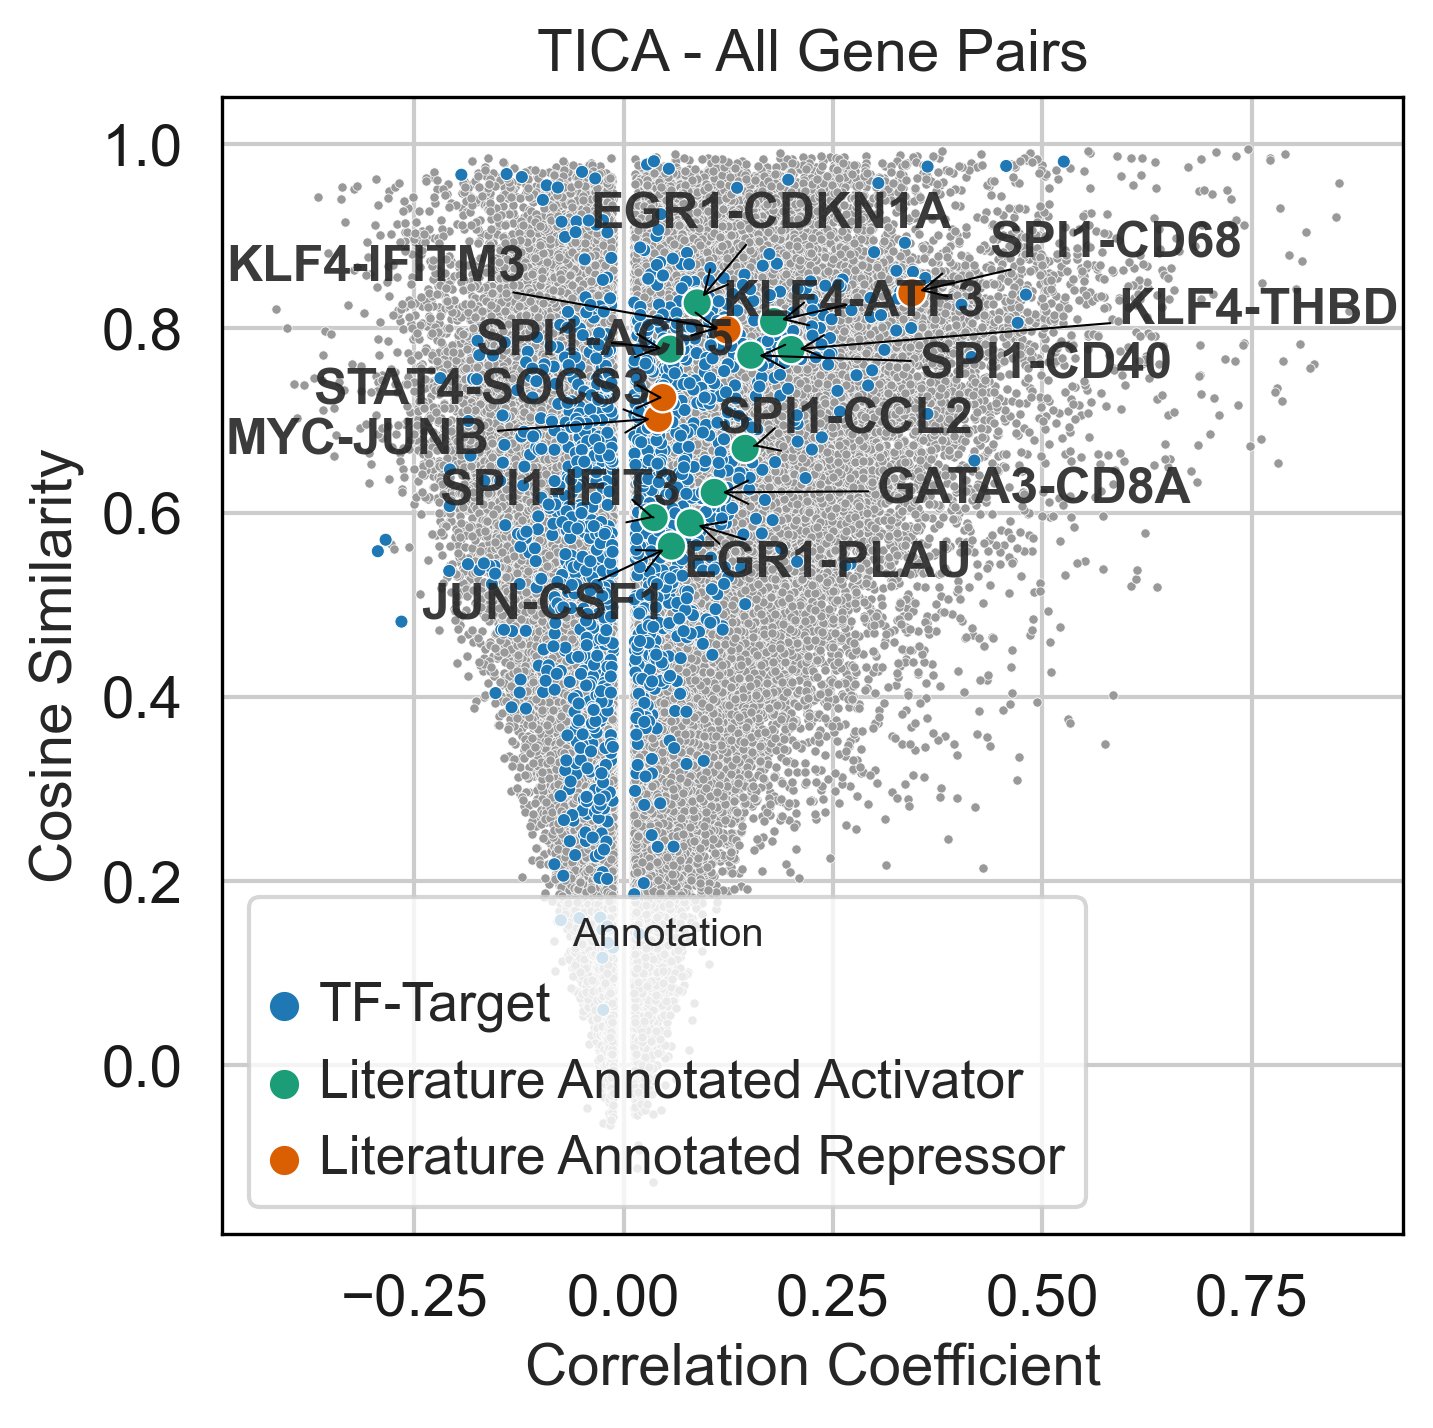

In [41]:
df = pandas.DataFrame.from_dict({"Corr":correlations,"MI":mis,"Cosine":cosine,"Regulation":tflabel,"TF":tf,"Pair":pairs})
df = df[df["Corr"]!=0.]
annotation = []
for x,y in zip(df["Regulation"],df["TF"]):
    if y != "TF-Target":
        annotation.append("Gene Pair")
    elif y == "TF-Target" and x == "_Other":
        annotation.append("ChIP-Seq TF-Target")
    else:
        annotation.append("Literature Annotated {}".format(x))
df["Annotation"] = annotation
df

import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150,facecolor='white')
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from adjustText import adjust_text

fig, ax = plt.subplots(1,1,figsize=(5,5))

acti = []
repres = []
text = []
sns.scatterplot(data=df,x="Corr",y="Cosine",color="#999999",ax=ax,s=5)
dfl = df[df["TF"]!="_Other"]
sns.scatterplot(data=dfl,x="Corr",y="Cosine",hue="TF",ax=ax,s=10)
dfl = dfl[dfl["Regulation"]!="_Other"]
sns.scatterplot(data=dfl,x="Corr",y="Cosine",hue="Annotation",ax=ax,s=50,palette="Dark2")

for x, y, l, r in zip(dfl["Corr"],dfl["Cosine"],dfl["Pair"],dfl["Regulation"]):
    if r == "Activator":
        text.append(ax.text(x, y, l, fontsize=12, alpha=0.9, fontweight="bold"))
        acti.append(l)
    if r == "Repressor":
        text.append(ax.text(x, y, l, fontsize=12, alpha=0.9, fontweight="bold"))
        repres.append(l)
adjust_text(text,ax=ax,arrowprops=dict(arrowstyle="->", color='black', lw=0.5))


ax.set_ylabel("Cosine Similarity")
ax.set_xlabel("Correlation Coefficient")
ax.set_title("TICA - All Gene Pairs")

plt.tight_layout()

{'Myeloid', 'B/Plasma', 'T Cell'}
                                            SOCS3     STAT4
cell_type                                                  
B cells                                 -0.233322 -0.169937
Cytotoxic CD8 T cells                   -0.141712  0.368588
Effector memory CD8 T cells              0.250222 -0.014160
M2 TAMs                                  0.082997 -0.309886
Mast cells                              -0.140472 -0.247090
Monocytes                                0.177635 -0.328795
NK                                      -0.251750  0.335641
Naive T cells                            0.289184  0.307995
Naive-memory CD4 T cells                -0.098332 -0.006074
Plasma B cells                          -0.240249 -0.334579
Pre-exhausted CD8 T cells                0.097582  0.237621
Proinflamatory TAMs                      0.514025 -0.285022
Proliferative B cells                   -0.316927 -0.292528
Proliferative T cells                   -0.191619  0.095664
Prolif

<AxesSubplot: xlabel='THBD', ylabel='KLF4'>

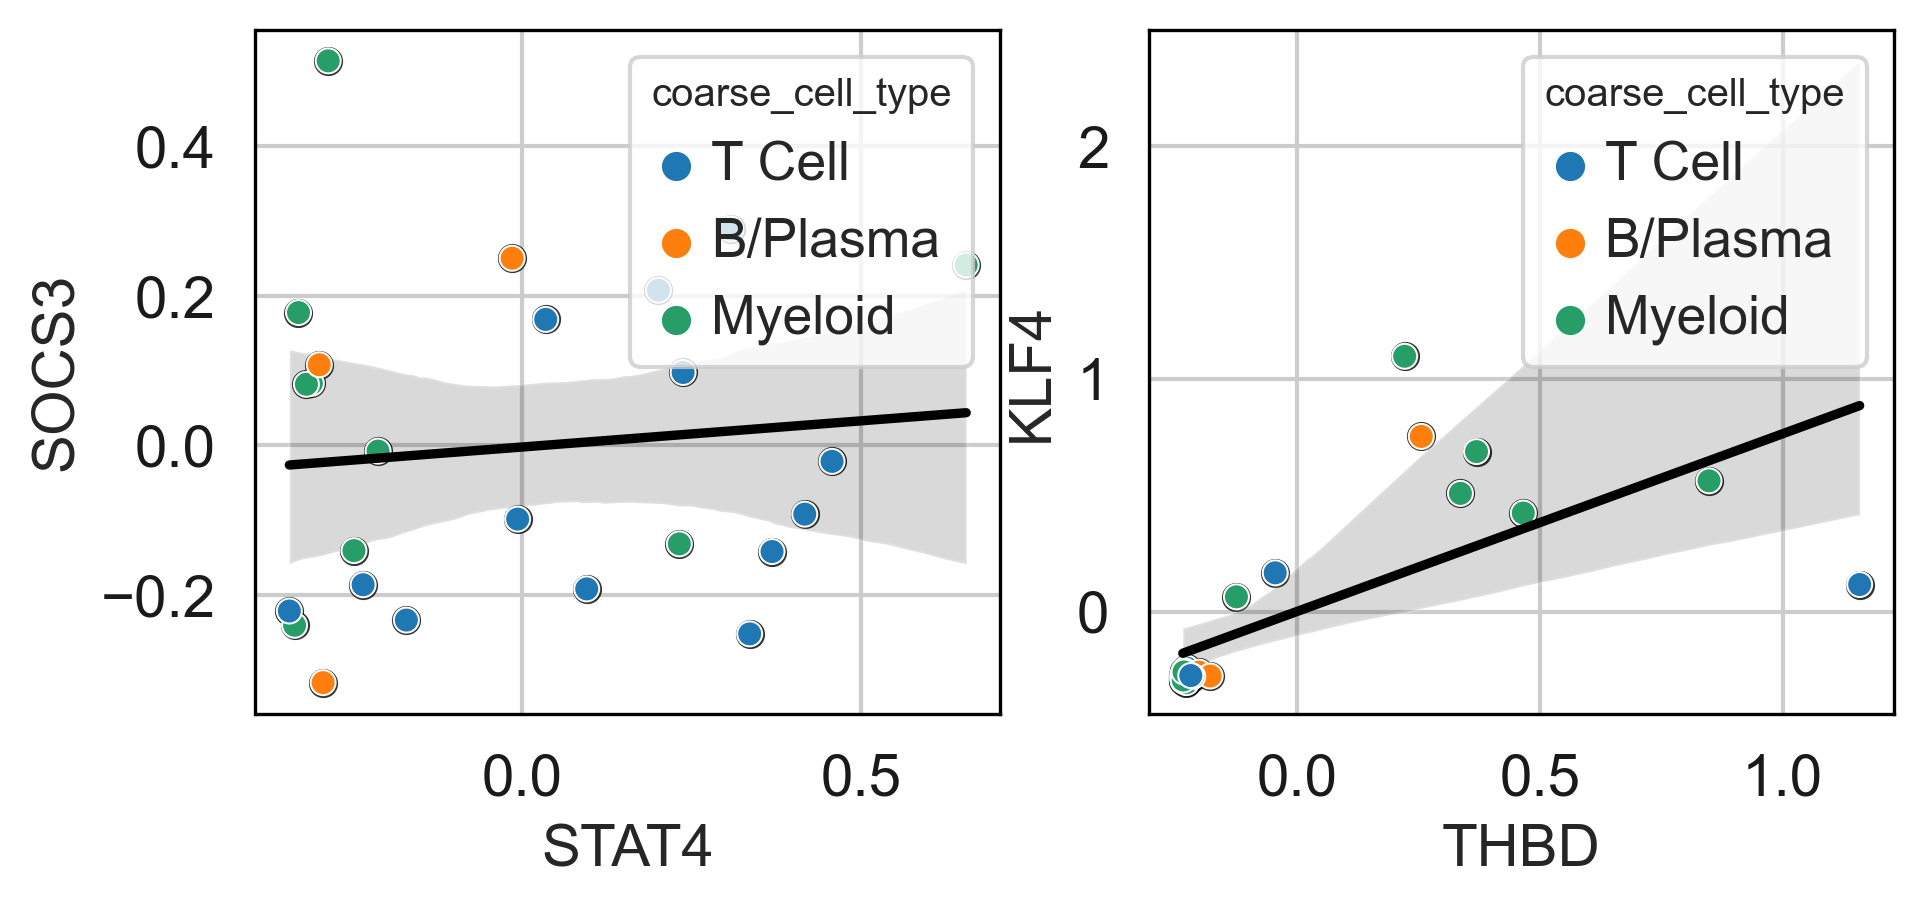

In [45]:
ct = []
for x in adata.obs["cell_type"]:
    if "T " in x:
        ct.append("T Cell")
    elif "mDC" in x or "cDC" in x or "pDC" in x:
        ct.append("Myeloid")
    elif "mono" in x.lower():
        ct.append("Myeloid")
    elif "TAM" in x:
        ct.append("Myeloid")
    elif "B " in x:
        ct.append("B/Plasma")
    elif "NK" in x:
        ct.append("T Cell")
    elif "Th" in x:
        ct.append("T Cell")
    elif "Mast" in x:
        ct.append("Myeloid")
    else:
        ct.append(x)
print(set(ct))
adata.obs["coarse_cell_type"] = ct

cts1 = []
df = adata[:,["SOCS3","STAT4"]]
df = df.to_df()
df["cell_type"] = adata.obs["cell_type"]
df = df.groupby("cell_type").mean()
print(df)
df["counts"] = [len(adata[adata.obs["cell_type"]==x].obs.index) for x in df.index]

ctd = dict(zip(adata.obs["cell_type"],adata.obs["coarse_cell_type"]))
print(ctd)
coarse = []
for x in set(df.index):
    coarse.append(ctd[x])
df["coarse_cell_type"] = coarse

fig,ax=plt.subplots(1,2,figsize=(7,3))
sns.regplot(data=df,x="STAT4",y="SOCS3",color="#000000",ax=ax[0])
sns.scatterplot(data=df,x="STAT4",y="SOCS3", hue="coarse_cell_type",ax=ax[0])



df = adata[:,["THBD","KLF4"]]
df = df.to_df()
df["cell_type"] = adata.obs["cell_type"]
df = df.groupby("cell_type").mean()
print(df)
df["counts"] = [len(adata[adata.obs["cell_type"]==x].obs.index) for x in df.index]

ctd = dict(zip(adata.obs["cell_type"],adata.obs["coarse_cell_type"]))
print(ctd)
coarse = []
for x in set(df.index):
    coarse.append(ctd[x])
df["coarse_cell_type"] = coarse

sns.regplot(data=df,x="THBD",y="KLF4",color="#000000",ax=ax[1])
sns.scatterplot(data=df,x="THBD",y="KLF4", hue="coarse_cell_type",ax=ax[1])


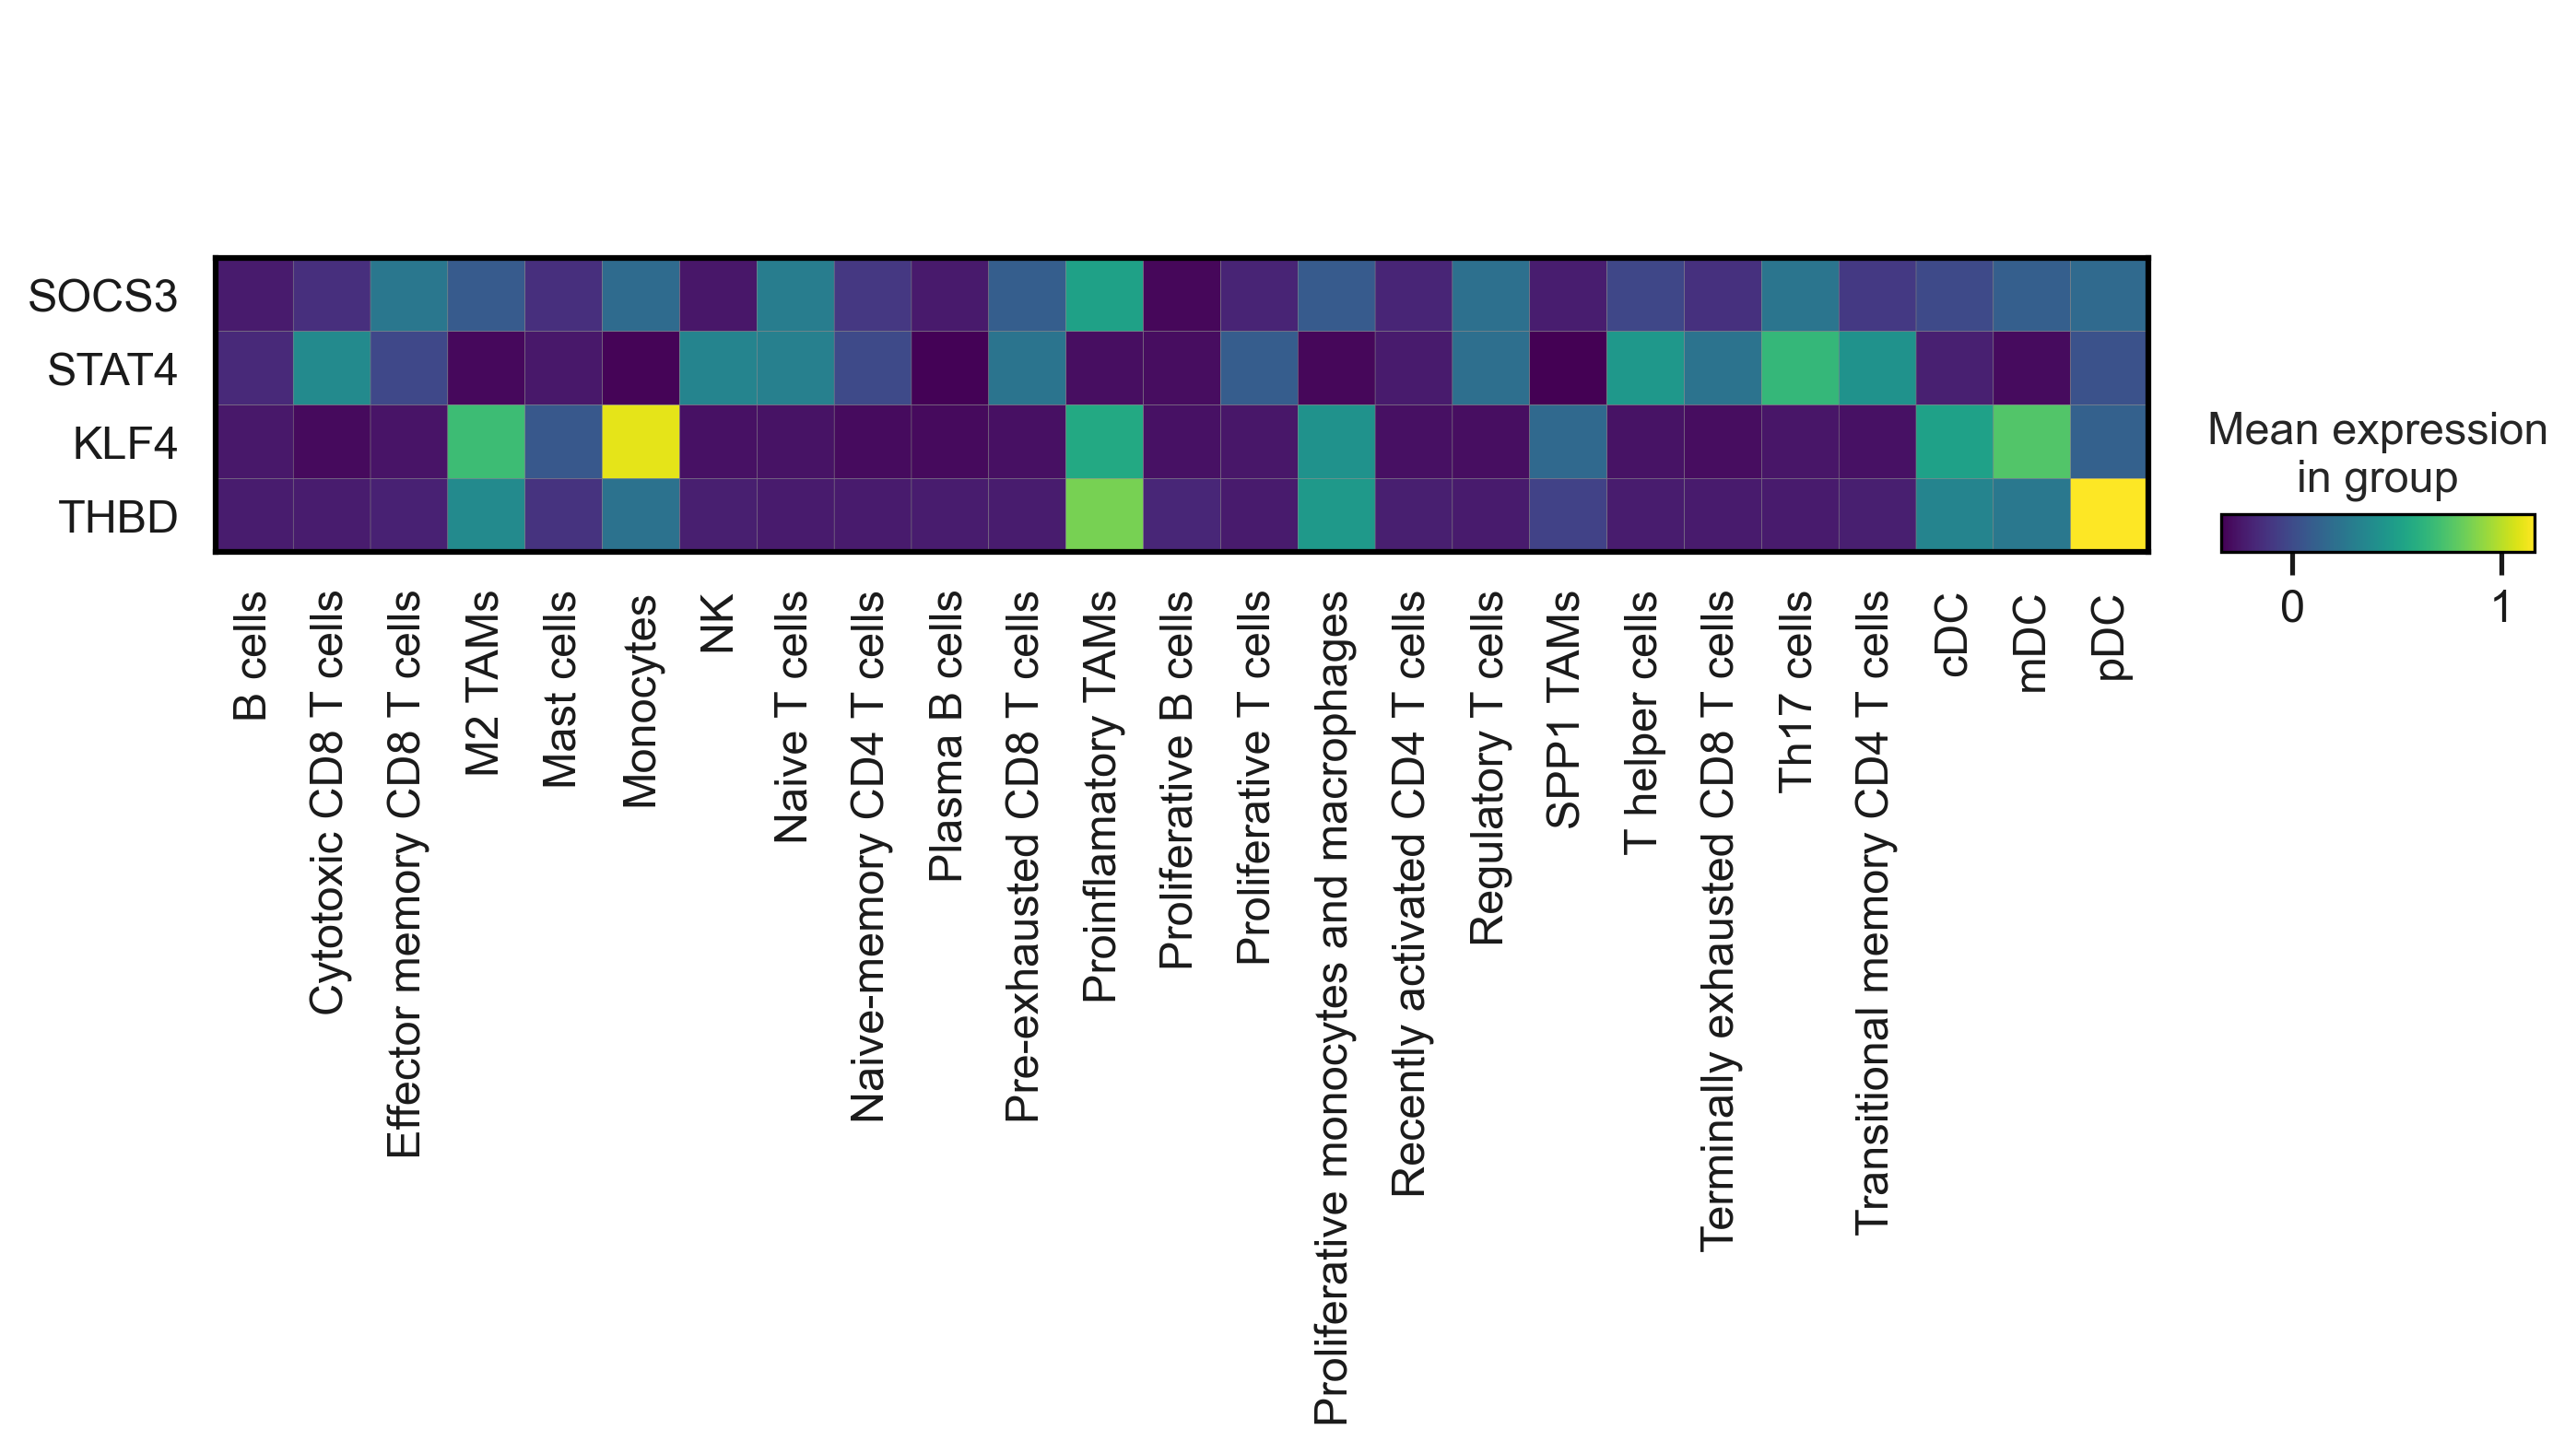

In [46]:
sc.pl.matrixplot(adata,["SOCS3","STAT4","KLF4","THBD"],groupby="cell_type",swap_axes=True)

# Compare Classification with CellAssign

In [49]:
raw = sc.read_10x_h5("/Users/ceglian/Analysis/chow/tilv2/1559a_IGO_10243_AL_1_GEX.h5")
protein_coding = set(raw.var.index.tolist())
adata = sc.read("/Users/ceglian/Downloads/TICAtlas_downsampled_1000.h5ad")
adata = adata.raw.to_adata()
adata.X = adata.X.astype(int)
adata.var
adata.var.index = adata.var["_index"]
del adata.var["_index"]
genes = adata.var.index.tolist()
genes = [x for x in genes if x in protein_coding]

adata = adata[:,genes]

adata
sc.pp.calculate_qc_metrics(adata,inplace=True)
adata.obs
sc.pp.filter_cells(adata, min_counts=300)
adata.write("tica_cellassign.h5ad")
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / numpy.mean(lib_size)

reading /Users/ceglian/Analysis/chow/tilv2/1559a_IGO_10243_AL_1_GEX.h5
 (0:00:00)


/Users/ceglian/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/ceglian/miniconda3/lib/python3.9/site-packages/anndata/_core/raw.py:139: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/Users/ceglian/miniconda3/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automati

filtered out 1353 cells that have less than 300 counts


In [50]:
markers_orig = dict()
markers_orig["T Cell"] = ["CD3D","CD3G","CD3E","TRAC","IL32","CD2"]
markers_orig["B/Plasma"] = ["CD79A","CD79B","MZB1","CD19","BANK1"]
markers_orig["Myeloid"] = ["LYZ","CST3","AIF1","CD68","C1QA","C1QB","C1QC"]

In [51]:
import numpy
all_genes = set()
for gs in markers_orig.values():
    for g in gs:
        all_genes.add(g)
all_genes = list(all_genes)
matrix = []
cts = list(markers_orig.keys())
for g in all_genes:
    row = []
    for ct in cts:
        if g in markers_orig[ct]:
            row.append(1)
        else:
            row.append(0)
    matrix.append(row)
matrix = numpy.array(matrix)
import pandas
dfmarkers = pandas.DataFrame(data=matrix,index=all_genes)
dfmarkers.columns = cts
marker_gene_mat = dfmarkers
marker_gene_mat

T Cell  B/Plasma  Myeloid
BANK1       0         1        0
C1QB        0         0        1
C1QC        0         0        1
C1QA        0         0        1
MZB1        0         1        0
CD79B       0         1        0
CD79A       0         1        0
CD19        0         1        0
AIF1        0         0        1
CD68        0         0        1
TRAC        1         0        0
CD3G        1         0        0
IL32        1         0        0
CST3        0         0        1
CD3E        1         0        0
CD3D        1         0        0
CD2         1         0        0
LYZ         0         0        1

In [53]:
import scvi
bdata = adata[:, marker_gene_mat.index].copy()
scvi.external.CellAssign.setup_anndata(bdata, size_factor_key="size_factor")

Global seed set to 0
/Users/ceglian/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [54]:
from scvi.external import CellAssign
model = CellAssign(bdata, marker_gene_mat)
model.train(max_epochs=400)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ceglian/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/ceglian/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:258: LightningDeprecationWarning: The `Callback.on_batch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `Callback.on_train_batch_end` instead.
  rank_zero_deprecation(


Epoch 283/400:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 283/400 [01:21<00:33,  3.46it/s, loss=17.9, v_num=1]
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 18.019. Signaling Trainer to stop.


0.07478386780801499


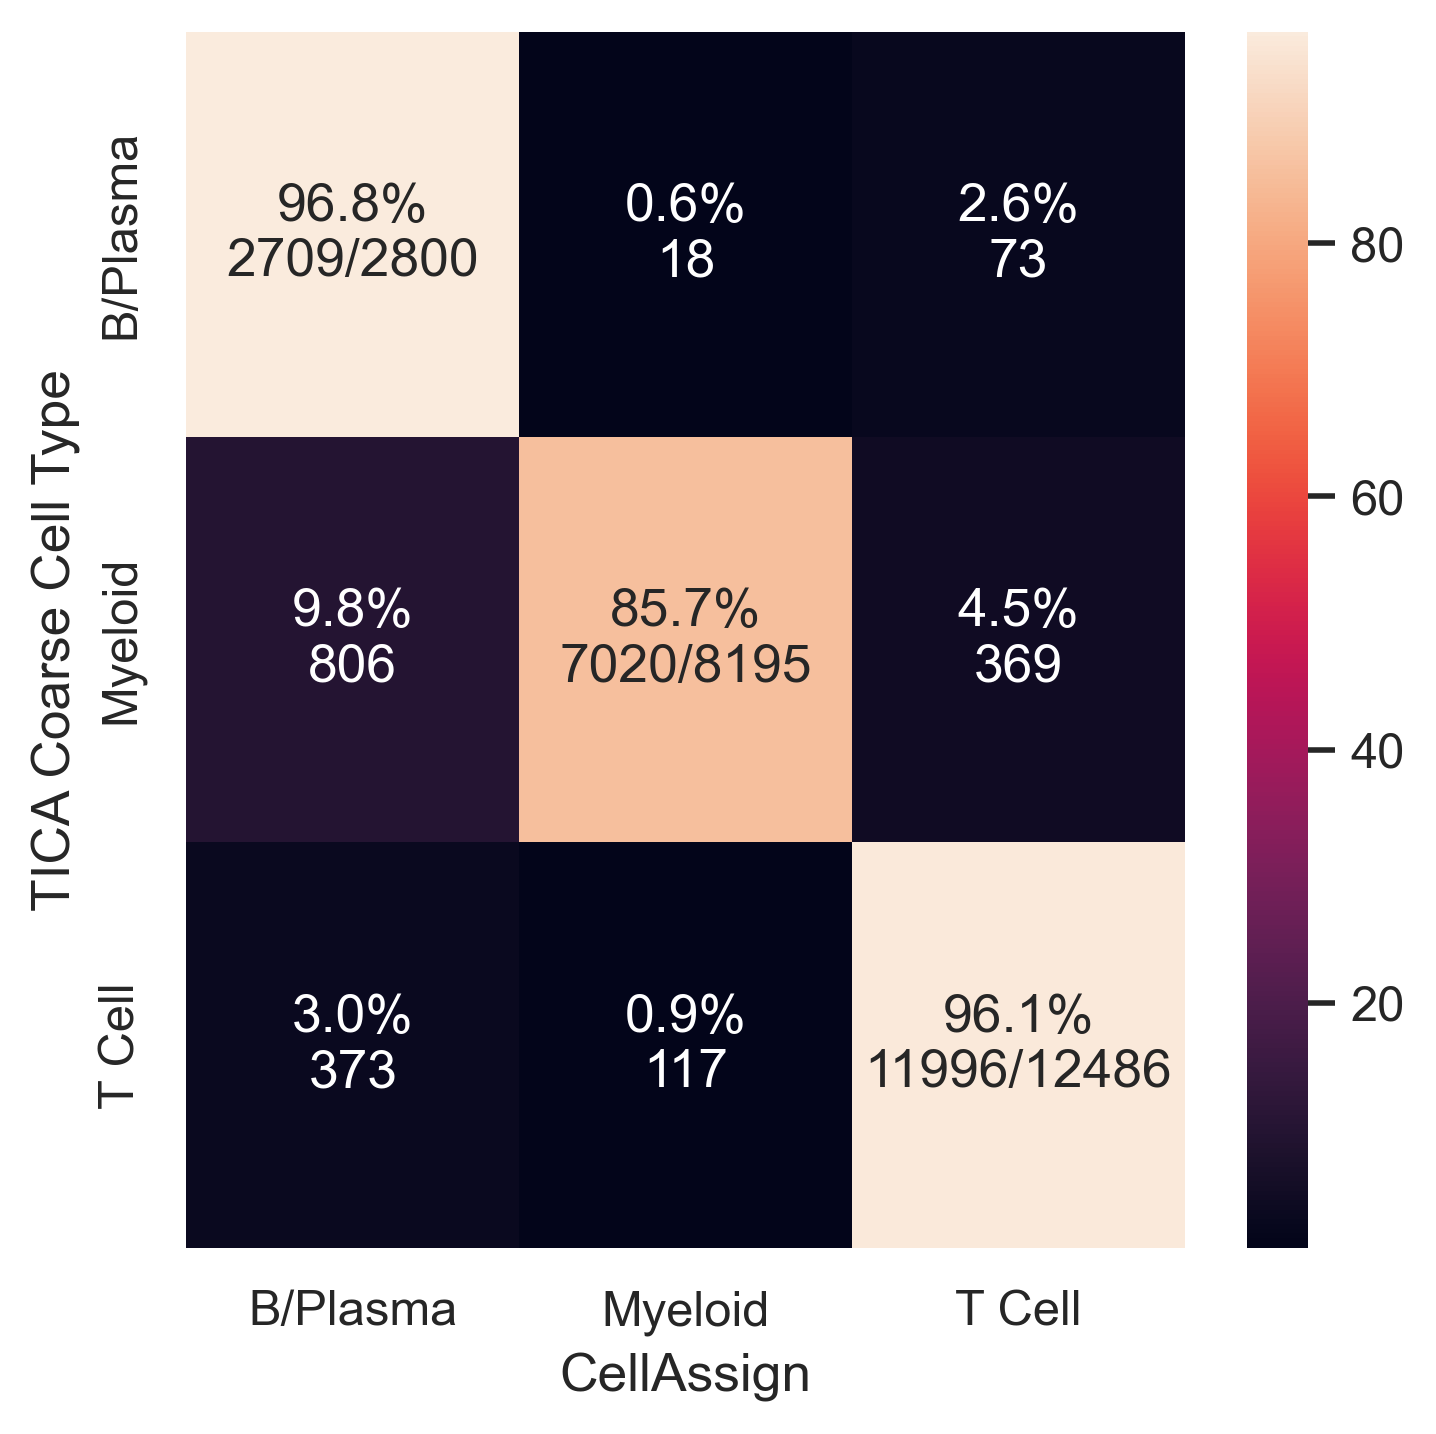

In [58]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns

sns.set(font_scale=1.)

model.history["elbo_validation"].plot()
predictions = model.predict()
predictions.head()
bdata.obs["scvi-tools predictions"] = predictions.idxmax(axis=1).values


def plot_cm(y_true, y_pred, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm_perc = pd.DataFrame(cm_perc, index=np.unique(y_true), columns=np.unique(y_true))
    cm_perc.index.name = 'TICA Coarse Cell Type'
    cm_perc.columns.name = 'CellAssign'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', ax=ax,annot_kws={"size": 12})

ct2 = []
for x in bdata.obs["cell_type"]:
    if "T " in x:
        ct2.append("T Cell")
    elif "mDC" in x or "cDC" in x or "pDC" in x:
        ct2.append("Myeloid")
    elif "mono" in x.lower():
        ct2.append("Myeloid")
    elif "TAM" in x:
        ct2.append("Myeloid")
    elif "B " in x:
        ct2.append("B/Plasma")
    elif "NK" in x:
        ct2.append("T Cell")
    elif "Th" in x:
        ct2.append("T Cell")
    elif "Mast" in x:
        ct2.append("Myeloid")
    else:
        ct2.append(x)

bdata.obs["coarse_cell_type"] = ct2

ca_ct_orig = bdata.obs["scvi-tools predictions"].tolist()
tica_ct_orig = bdata.obs["coarse_cell_type"].tolist()
plot_cm(tica_ct_orig,ca_ct_orig)


incorrect = 0
total = 0
for x,y in zip(bdata.obs["coarse_cell_type"],bdata.obs["scvi-tools predictions"]):
    if x!=y:
        incorrect += 1
    total+=1
print(incorrect/total)